In this notebook, we will train the model on only 7 labels, namely the Ekman labels. 

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Is gpu available?', device=='cuda')
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from transformers import pipeline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from datasets import load_dataset

Is gpu available? True


In [2]:
dataset = load_dataset("csv",data_files=
                       {"train": "../reformat_data/train_wide.csv",
                        "validation": "../reformat_data/val_wide.csv",
                         "test": "../reformat_data/test_wide.csv"})

Found cached dataset csv (C:/Users/lkkcp/.cache/huggingface/datasets/csv/default-af6254ecd422efea/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import json
with open('../data/ekman_mapping.json','r') as f:
    ekman_map = json.load(f)

In [20]:
ekman_map['neutral'] = ['neutral']
ekman_map

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity'],
 'neutral': ['neutral']}

In [21]:
labels = list(ekman_map.keys())
labels

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

In [43]:
lab2idx = {labels[i]:i for i in range(len(labels))}
idx2lab = {i:labels[i] for i in range(len(labels))}

In [9]:
# Hyperparameters
model_checkpoint = "roberta-base"
MAXLEN = 256
batch_size = 4
metric_name = 'f1'
epochs = 10
weight_decay = 0.01
learning_rate = 1e-5

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [50]:
def encode(samples):
    return tokenizer(samples['Text'], padding="max_length",truncation=True, max_length=MAXLEN)

# This function reduces the number of labels to 7, according to the Ekman map
def label_formatting(samples):
    labels_matrix = np.zeros((len(samples['Text']), len(labels)))
    for i, label in enumerate(labels):
        for sublabel in ekman_map[label]:
            labels_matrix[:,i] += samples[sublabel]
    labels_matrix = (labels_matrix>0).astype(float)
    return {'labels':labels_matrix.tolist()}
temp = dataset.map(encode,batched=True)
encoded_dataset = temp.map(label_formatting,batched=True,remove_columns=dataset['train'].column_names)
encoded_dataset.set_format("torch")

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [48]:
def multi_label_metrics(predictions, y_true, threshold=0.5):

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs >= threshold).long()
    
    f1_micro_average = f1_score(y_true, y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        preds, p.label_ids)
    return result

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                       problem_type="multi_label_classification", 
                                                       num_labels=len(labels),
                                                       id2label=idx2lab,
                                                       label2id=lab2idx).to(device)


args = TrainingArguments(
    f"{model_checkpoint}-goemotions-ekman",
    evaluation_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.241800,0.226051,0.684427,0.800965,0.603391
2,0.207200,0.227539,0.699281,0.813547,0.627534
3,0.185000,0.236473,0.698520,0.810693,0.631589
4,0.163600,0.269092,0.699965,0.816387,0.633247
5,0.143700,0.301776,0.686884,0.809627,0.619241
6,0.126100,0.357025,0.678056,0.805871,0.608183
7,0.110100,0.382192,0.682696,0.808519,0.617951
8,0.096100,0.417330,0.674861,0.805226,0.603391
9,0.084000,0.444851,0.677943,0.806868,0.608183
10,0.075100,0.456524,0.676064,0.805767,0.607999


TrainOutput(global_step=108530, training_loss=0.14327566184987015, metrics={'train_runtime': 30743.8544, 'train_samples_per_second': 14.12, 'train_steps_per_second': 3.53, 'total_flos': 5.711081832576e+16, 'train_loss': 0.14327566184987015, 'epoch': 10.0})

In [52]:
trainer.evaluate()

{'eval_loss': 0.2690916657447815,
 'eval_f1': 0.6999653139091225,
 'eval_roc_auc': 0.8163865429836509,
 'eval_accuracy': 0.6332473276815334,
 'eval_runtime': 104.5017,
 'eval_samples_per_second': 51.923,
 'eval_steps_per_second': 12.985,
 'epoch': 10.0}

In [53]:
history_df = pd.DataFrame(trainer.state.log_history[:-2]) #The last two rows are final evaluations
history_df

,loss,learning_rate,epoch,step,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.2418,0.000009,1.0,10853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,10853,0.226051,0.684427,0.800965,0.603391,104.2420,52.052,13.018
2,0.2072,0.000008,2.0,21706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,21706,0.227539,0.699281,0.813547,0.627534,104.1884,52.079,13.024
4,0.1850,0.000007,3.0,32559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.0,32559,0.236473,0.698520,0.810693,0.631589,103.9913,52.177,13.049
6,0.1636,0.000006,4.0,43412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.0,43412,0.269092,0.699965,0.816387,0.633247,104.3879,51.979,13.000
8,0.1437,0.000005,5.0,54265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.0,54265,0.301776,0.686884,0.809627,0.619241,104.6338,51.857,12.969


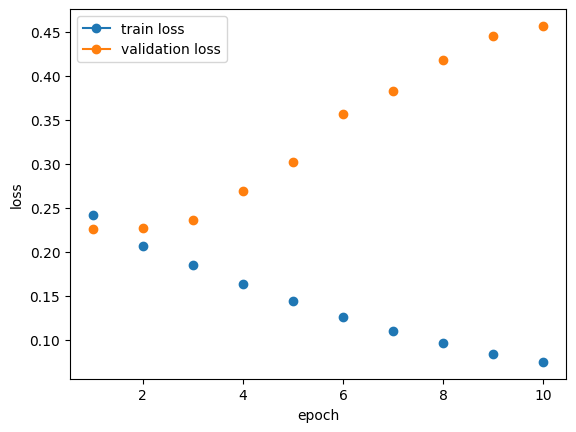

In [54]:
plt.plot(history_df['epoch'], history_df['loss'],'-o',label='train loss')
plt.plot(history_df['epoch'], history_df['eval_loss'],'-o',label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

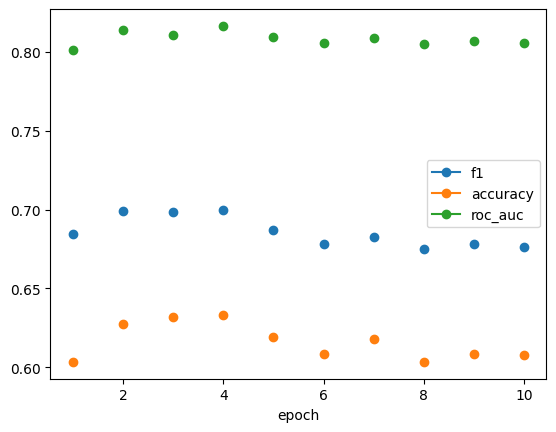

In [55]:
plt.plot(history_df['epoch'], history_df['eval_f1'],'-o',label='f1')
plt.plot(history_df['epoch'], history_df['eval_accuracy'],'-o',label='accuracy')
plt.plot(history_df['epoch'], history_df['eval_roc_auc'],'-o',label='roc_auc')
plt.legend()
plt.xlabel('epoch')
#plt.ylabel()
plt.show();

In [56]:
trainer.save_model('roberta-base-goemotions-ekman')
pd.DataFrame(trainer.state.log_history).to_csv('roberta-base-goemotions-ekman/training_log.csv')

# Evaluate on test data

In [57]:
trainer.evaluate(encoded_dataset['test'])

{'eval_loss': 0.27407875657081604,
 'eval_f1': 0.6913365259033523,
 'eval_roc_auc': 0.8115300146277437,
 'eval_accuracy': 0.6244702413856643,
 'eval_runtime': 81.3016,
 'eval_samples_per_second': 66.751,
 'eval_steps_per_second': 16.691,
 'epoch': 10.0}